<h1><center> ASI exercise </center></h1>
Student: HUYNH Viet Phi

In [1]:
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import mutual_info_classif
import glob
import sklearn.metrics.pairwise as pw
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import time
import warnings
warnings.filterwarnings('ignore')

## <font color='violet'> 1. Download and Import Fashion MNIST and CIFAR10 </font>

** Fashion MNIST  **

In [2]:
# Load train & test Fashin MNIST
mnist_train = pd.read_csv('./input/Fashion_MNIST/fashion-mnist_train.csv')
mnist_train = mnist_train.values
mnist_test = pd.read_csv('./input/Fashion_MNIST/fashion-mnist_test.csv')
mnist_test = mnist_test.values
# Seperate label & feature in train & test data
mnist_train_label = mnist_train[:,0]
mnist_train = mnist_train[:,1:]
mnist_test_label = mnist_test[:,0]
mnist_test = mnist_test[:,1:]

print("Dimension of fashion MNIST training set: ", mnist_train.shape)
print("Dimension of fashion MNIST testing set: ", mnist_test.shape)

('Dimension of fashion MNIST training set: ', (60000, 784))
('Dimension of fashion MNIST testing set: ', (10000, 784))


** CIFAR10 **

In [3]:
# Function to load CIFAR dataset
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

# List CIFAR files
files = glob.glob('./input/CIFAR/*')
# Load CIFAR test dataset
cifar_test = unpickle(files[0])
cifar_test_label = np.array(cifar_test['labels'])
cifar_test = cifar_test['data']
# Load CIFAR train dataset
cifar_train = []
cifar_train_label = []
for file_ in files[1:]:
    cifar_train_tmp = unpickle(file_)
    cifar_train_label.append(cifar_train_tmp['labels'])   
    cifar_train.append(cifar_train_tmp['data'])     
cifar_train = np.vstack(cifar_train)
cifar_train_label = np.array(sum(cifar_train_label, []))

print("Dimension of CIFAR10 training set: ", cifar_train.shape)
print("Dimension of CIFAR10 testing set: ", cifar_test.shape)

('Dimension of CIFAR10 training set: ', (50000, 3072))
('Dimension of CIFAR10 testing set: ', (10000, 3072))


## <font color='violet'> 2. Distribution of class labels and the dimensionality of the input </font>

** Fashion MNIST **

Numner of class labels in MNIST: 10


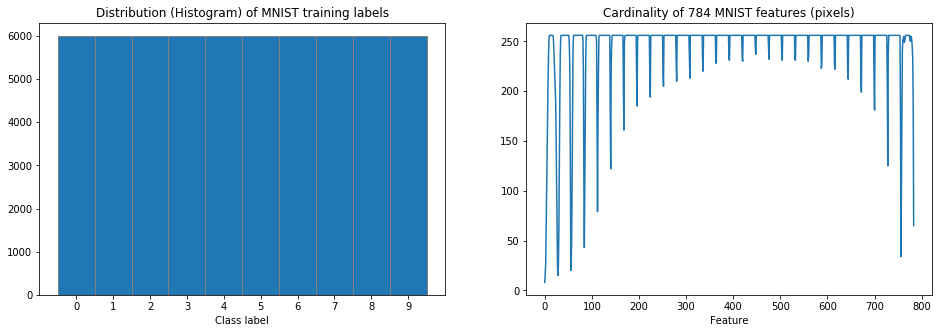

In [5]:
plt.figure(figsize=(16,5))
## Distribution of labels
plt.subplot(121)
print 'Numner of class labels in MNIST: ' +  str(len(np.unique(mnist_train_label)))
plt.hist(mnist_train_label, edgecolor='gray', align='mid', bins=np.arange(0,11)-0.5)
plt.xticks(np.unique(mnist_train_label))
plt.title('Distribution (Histogram) of MNIST training labels')
plt.xlabel('Class label')

## Dimensionality of feature
plt.subplot(122)
cardinality_of_features = []
for feature in range(mnist_train.shape[1]):
    unique_val = np.unique(mnist_train[:,feature])
    cardinality_of_features.append(len(unique_val))
plt.plot(cardinality_of_features)
plt.title('Cardinality of 784 MNIST features (pixels)')
plt.xlabel('Feature')
plt.show()

** Comment ** 

The class labels are uniformly distributed in both MNIST testing and training set. This can help us to avoid the class-imbalance related problems. One is that Naive Bayes will shrink weights for classes with very few examples than another, this leads to poor weights for decision boundary. Also, a class balance allows to use simple classification accuracy as metric to evaluate the model. When there is a high class imbalance, Area Under Receiver Operating Characteristic Curves metric (AUROC) is more relevant and useful.

MNIST has high-dimensional feature vectors (784). High dimensionality can cause the existence of many noise features that do not have considerable contributions to the classfication. As we can see from the above plot "Cardinality of 784 MNIST pixels", there are some pixels with small value range. They can be border pixels of image which do not actually contain discriminative information. By making a conditional independence assumption, Naive Bayes Classifier can mitigate the "curse-of-dimensionality", but from retaining such trivial features, it might also accumulate the error (noise) during likelihood computing step, which could increase the misclassification ratio. Thus dimension reduction and feature selection are necessary pre-processing step in high dimensional classification.

** CIFAR10 **

Numner of class labels in CIFAR: 10


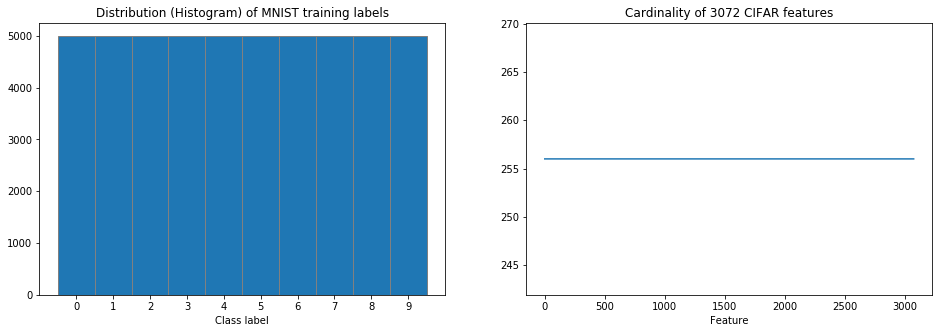

In [6]:
plt.figure(figsize=(16,5))
## Distribution of labels
plt.subplot(121)
print 'Numner of class labels in CIFAR: ' + str(len(np.unique(cifar_train_label)))
plt.hist(cifar_train_label, edgecolor='gray', align='mid', bins=np.arange(0,11)-0.5)
plt.xticks(np.unique(cifar_train_label))
plt.title('Distribution (Histogram) of MNIST training labels')
plt.xlabel('Class label')

## Dimensionality of feature
plt.subplot(122)
cardinality_of_features = []
for feature in range(cifar_train.shape[1]):
    unique_val = np.unique(cifar_train[:,feature])
    cardinality_of_features.append(len(unique_val))
plt.plot(cardinality_of_features)
plt.title('Cardinality of 3072 CIFAR features')
plt.xlabel('Feature')
plt.show()

** Comment ** 

The class labels are uniformly distributed in both CIFAR testing and training set. Thus we can have same observations as MNIST case

CIFAR10 is made of RGB 32*32 images, which eventually represented by  vectors of 3072 dimension. Moreover, as shown in figure "cardinality of CIFAR features", each dimension (pixel) is filled by all values from [0..255]. This makes CIFAR data more complex than MNIST with an intuition that every pixel in CIFAR can cause the classifier certain confusions. 

## <font color='violet'> 3. Naive Bayes Classification </font> 

###  <font color='green'> 3a. Implement Naive Bayes Classifier </font>

We treat feature vectors as both continous and discrete-valued vectors. If discrete, we model features with a multinomial distribution over target. If continous, gaussian distribution would be used.

Also, we assume that class labels have categorical distribution. Maximum Joint Likelihood of data will give the maximum likelihood estimate of the parameters of prior and conditional distribution as below:

** Bayes Prior **

In [7]:
def Bayes_Prior(training_label):
    unique_label, count_label = np.unique(training_label, return_counts=True) 
    prob_label = count_label*1.0/len(training_label)
    prior = dict(zip(unique_label, prob_label))
    return prior

** Bayes Likelihood  **

* In Multinomial Naive Bayes, to prevent zero probabilities of events not present in training data, from which log transform cannot compute, we use Laplace smoothing by adding 1 to the numerator and 256 to the denominator in the estimate.

In [8]:
def Bayes_Likelihood(training_features, training_labels, pdf = 'multinomial', laplace_denom = 256):
    likelihood = {} # store likelihood for each label
    labels = np.unique(training_labels)
    for label in labels:
        c_training = training_features[training_labels == label]
        # multinomial likelihood
        if (pdf == 'multinomial'):
            pdf_ = np.ones([laplace_denom, c_training.shape[1]])/(laplace_denom + c_training.shape[0])
            for i_feature in range(c_training.shape[1]):           
                # count frequency for each pixel in a feature (column), then calculate prob accordingly
                pixel, pixel_count = np.unique(c_training[:,i_feature], return_counts= True)
                prob_pixel = (1.0 + pixel_count)/(laplace_denom + c_training.shape[0])
                pdf_[pixel, i_feature] = prob_pixel
        # gaussian likelihood
        elif (pdf == 'gaussian'):
            pdf_ = {}
            pdf_['mean'] = np.mean(c_training, axis = 0) # compute for each feature (column)
            pdf_['std'] = np.std(c_training, axis = 0) 
        else:
            print("Unsupported distribution")
            return  
        likelihood[label] = pdf_
    return likelihood

** Bayes Posterior ( Prediction) **

By calculating the posterior probability of each class, we predict the class with highest prob accordingly 
* To avoid numerical problems in calculating normalization part (log of sum of multiple joint log likelihood) in posterior prob, we use transformation: 
$ log (a + b) = log(a) + log(1+ exp(log(b) - log(a)) $

In [9]:
def Bayes_Predict(test_set, prior, likelihood, pdf = 'multinomial'):
    # calculate joint loglikelihood (numerator)
    joint_log_likelihood = []   
    for label in prior:
        log_prior_ = np.log(prior[label])
        if (pdf == 'multinomial'):           
            # all likelihood P(X=i|Y=j) are already storeed in variable likelihood
            log_prob_likelihood_ = np.sum(np.log(likelihood[label][test_set,range(test_set.shape[1])]), 1)     
            joint_log_likelihood.append(log_prior_ + log_prob_likelihood_)
        elif (pdf == 'gaussian'): 
            # variable likelihood contains gaussian mean and variance for each label
            # we log-transform gaussian pdf
            log_prob_likelihood_ = - 0.5 * np.sum(np.log(2. * np.pi * likelihood[label]['std']**2))
            log_prob_likelihood_ -= 0.5 * np.sum(((test_set - likelihood[label]['mean']) ** 2) /
                                        (likelihood[label]['std']**2), 1)    
            joint_log_likelihood.append(log_prior_ + log_prob_likelihood_)
        else:
            print("Unsupported distribution")
            return 
                                                 
    joint_log_likelihood = np.array(joint_log_likelihood).T                                                 
    predict = np.argmax(joint_log_likelihood, 1) # classify according to highest joint_loglikelihood
    # calculate posterior
    test_log_likelihood = joint_log_likelihood - np.max(joint_log_likelihood, 1).reshape(-1,1)
    test_log_likelihood = -np.log(np.sum(np.exp(test_log_likelihood),1))
    return predict, np.sum(test_log_likelihood)

** Accuracy & Confusion matrix **

In [10]:
def accuracy(prediction, ground_truth):
    prediction = np.array(prediction)
    ground_truth = np.array(ground_truth)
    return (1.0*sum(prediction == ground_truth)/len(ground_truth))

In [11]:
def plot_confusion_matrix(test_label, predict_label, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(test_label, predict_label)
    #plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###  <font color='green'> 3b. Pros. & Cons. of Naive Bayes classifier </font>

** Pros **

An advantage of Naive Bayes classifier is its simplicity and ease to implement. It is a relatively simple probabilistic method based on Bayes rule with a strong conditional independence assumptions between features. In addition, Naive Bayes classifier could also perform well with small or outlier-containing dataset. It's less sensitive to outlier, likely to come to the same classification decision whether there are slightly changes in training data (low-variance model).

** Cons **

Naive Bayes assumes that features are conditionally independent given class label, which is an extremely strong assumption. As a result, each feature is treated individually even if they are dependent. Hence, the classes with strong feature dependencies become dominant somehow, which may affect the decision boundary.

### <font color='green'> 3c. Data Pre-processing </font>

As we stated above the impact of high dimensionality on classification's performace, we perform Principal Component Analysis (PCA) (including zero-centering data step) to reduce the dimension that still contains most of information of large dataset. Another advantage of PCA is that feature vectors are converted from discrete form to continous form, which makes more sense for Gaussian Naive Bayes. Since Multinomial Naive Bayes consider discrete-valued vectors, we do not apply PCA in this classifier. 

### <font color='green'> 3de. Apply Naive Bayes classifier </font>

### Fashion MNIST

* ** Using Multinomial as conditional density**

---- Prediction accuracy: 0.741 -- Test log likelihood: -42.79301780922683


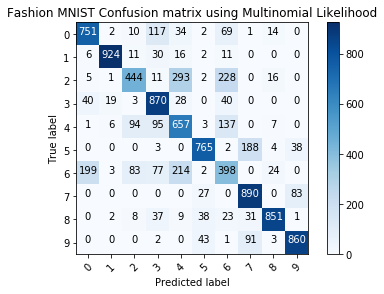

In [12]:
# prior of labels
mnist_prior = Bayes_Prior(mnist_train_label)
# multinomial likelihood
mnist_multinomial_likelihood = Bayes_Likelihood(mnist_train, mnist_train_label,'multinomial', 256)
# Calculate posterior and Prediction
mnist_predict, mnist_test_loglikelihood = Bayes_Predict(mnist_test, mnist_prior, mnist_multinomial_likelihood, 'multinomial')
print '---- Prediction accuracy: ' + str(accuracy(mnist_predict, mnist_test_label)) + ' -- Test log likelihood: ' + str(mnist_test_loglikelihood)
plot_confusion_matrix(mnist_test_label, mnist_predict, classes=np.unique(mnist_train_label),title='Fashion MNIST Confusion matrix using Multinomial Likelihood')

* ** Using Gaussian as conditional density**

We divide inital train set into 55000-sample new train set and 5000-sample validation set, then perform a LOOCV to select "good" number of PCA components to keep from [10:10:300] w.r.t classification accuracy. We start from N_PCA = 10 which keeps 72% total variances, and end at N_PCA = 300 which keeps 97% total variances

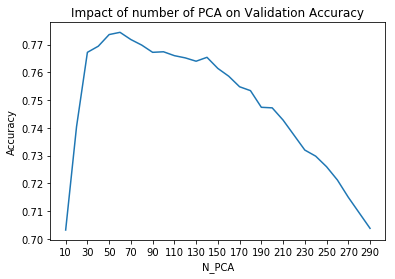

In [104]:
# take a small part from train as validation test
mnist_validation = mnist_train[-5000:]
mnist_validation_label = mnist_train_label[-5000:]
validation_error = []
for n_pca in range(10, 300, 10):
    pca = PCA(n_components=n_pca)
    # only fit PCA on train minus validation
    pca.fit(mnist_train[:-5000])
    # project train and validation into PCA space
    mnist_train_pca = pca.transform(mnist_train[:-5000])
    mnist_validation_pca = pca.transform(mnist_validation)
    # NB classifier on PCA space with gaussian likelihood
    mnist_gaussian_likelihood = Bayes_Likelihood(mnist_train_pca, mnist_train_label[:-5000],'gaussian')
    mnist_predict,_ = Bayes_Predict(mnist_validation_pca, mnist_prior, mnist_gaussian_likelihood, 'gaussian')
    validation_error.append(accuracy(mnist_predict, mnist_validation_label))   
plt.plot(range(10, 300, 10), validation_error)
plt.xlabel('N_PCA')
plt.ylabel('Accuracy')
plt.title('Impact of number of PCA on Validation Accuracy')
plt.show()

* According to plot above, we select 60 as final number of PCA components for MNIST 

---- Prediction accuracy: 0.7799 -- Test log likelihood: -1027.2216500975246


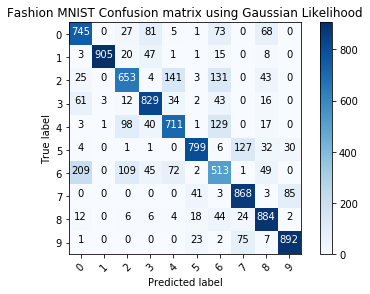

In [13]:
# fit PCA with N = 60
pca = PCA(n_components=60)
pca.fit(mnist_train)
# transfrom train & test set accordingly
mnist_train_pca = pca.transform(mnist_train)
mnist_test_pca = pca.transform(mnist_test)
# compute gaussian likelihood with PCA-based features
mnist_gaussian_likelihood = Bayes_Likelihood(mnist_train_pca, mnist_train_label,'gaussian')
# calculate posterior and prediction
mnist_predict, mnist_test_loglikelihood = Bayes_Predict(mnist_test_pca, mnist_prior, mnist_gaussian_likelihood, 'gaussian')
print '---- Prediction accuracy: ' + str(accuracy(mnist_predict, mnist_test_label)) + ' -- Test log likelihood: ' + str(mnist_test_loglikelihood)
plot_confusion_matrix(mnist_test_label, mnist_predict, classes=np.unique(mnist_test_label),title='Fashion MNIST Confusion matrix using Gaussian Likelihood')

### CIFAR10

* ** Using Multinomial as conditional density**

---- Prediction accuracy: 0.3048 --- Test log likelihood: -48.36240048129422


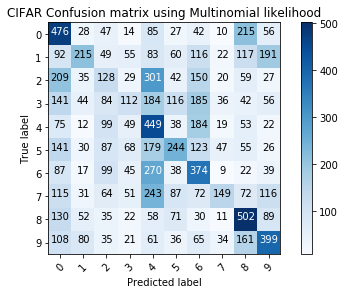

In [14]:
# prior of labels
cifar_prior = Bayes_Prior(cifar_train_label)
# multinomial likelihood
cifar_multinomial_likelihood = Bayes_Likelihood(cifar_train, cifar_train_label, 'multinomial', 256)
# posterior and prediction
cifar_predict, cifar_test_loglikelihood = Bayes_Predict(cifar_test, cifar_prior, cifar_multinomial_likelihood, 'multinomial')
print "---- Prediction accuracy: " + str(accuracy(cifar_predict, cifar_test_label)) + " --- Test log likelihood: " + str(cifar_test_loglikelihood)
plot_confusion_matrix(cifar_test_label, cifar_predict, classes=np.unique(cifar_test_label),title='CIFAR Confusion matrix using Multinomial likelihood')

* ** Using Gaussian as conditional density**

Same procedure to define "good" N_PCA as MNIST case. Here, We start from N_PCA = 50 which keeps 84% total variances, and end at N_PCA = 300 which keeps 97% total variances

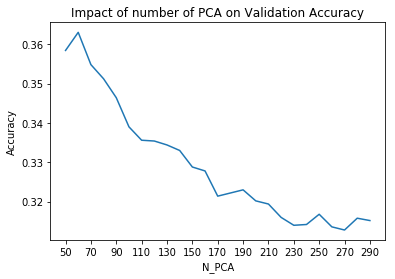

In [32]:
# take a small part from train as validation test
cifar_validation = cifar_train[-5000:]
cifar_validation_label = cifar_train_label[-5000:]
validation_error = []
for n_pca in range(50, 300, 10):
    pca = PCA(n_components=n_pca)
    # only fit PCA on train minus validation
    pca.fit(cifar_train[:-5000])
    # project train and validation into PCA space
    cifar_train_pca = pca.transform(cifar_train[:-5000])
    cifar_validation_pca = pca.transform(cifar_validation)
    # NB classifier on PCA space with gaussian likelihood
    cifar_gaussian_likelihood = Bayes_Likelihood(cifar_train_pca, cifar_train_label[:-5000],'gaussian')
    cifar_predict,_ = Bayes_Predict(cifar_validation_pca, cifar_prior, cifar_gaussian_likelihood, 'gaussian')
    validation_error.append(accuracy(cifar_predict, cifar_validation_label))   
plt.plot(range(50, 300, 10), validation_error)
plt.xlabel('N_PCA')
plt.ylabel('Accuracy')
plt.title('Impact of number of PCA on Validation Accuracy')
plt.show()

* According to plot above, we select 60 as final number of PCA components for CIFAR

---- Prediction accuracy: 0.353 --- Test log likelihood: -48.36240048129422


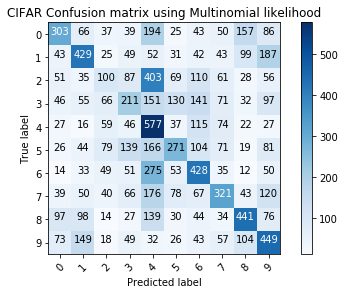

In [15]:
# pca transform
pca = PCA(n_components=60)
pca.fit(cifar_train)
cifar_train_pca = pca.transform(cifar_train)
cifar_test_pca = pca.transform(cifar_test)
# cifar gaussian likelihood
cifar_gaussian_likelihood = Bayes_Likelihood(cifar_train_pca, cifar_train_label,'gaussian')
# posterior and prediction
cifar_predict, ciafr_test_loglikelihood = Bayes_Predict(cifar_test_pca, cifar_prior, cifar_gaussian_likelihood, 'gaussian')
print "---- Prediction accuracy: " + str(accuracy(cifar_predict, cifar_test_label)) + " --- Test log likelihood: " + str(cifar_test_loglikelihood)
plot_confusion_matrix(cifar_test_label, cifar_predict, classes=np.unique(cifar_test_label),title='CIFAR Confusion matrix using Multinomial likelihood')

### <font color='green'> 3f. Evaluate the performance and Suggest way to improve accuracy </font>

Gaussian (resp. Multinomial) Naive Bayes classifier achives 78% (resp. 74%) accuracy on Fashion MNIST and 35% (resp. 30%) on CIFAR10. That's still better than guessing random class labels, which would give 10% accuracy since there are 10 classes. Also, with PCA pre-processing, Gaussian likelihood performs slightly better than Multinomial likelihood. It's relevant to use PCA in our case. Indeed, Gaussian likelihood gives much worse result if applied directly to original features. 

Considering the test loglikelihood:

+ In MNIST, we get -43 for Multinomial and -1207 for Gaussian NB, which means the average posterior of predicted class for Multinomial NB is ~ exp(-43/10000) = 99%, and ~ exp(-1207/10000) = 89% for Gaussian NB. We see that predicted class in Multinomial is strongly dominant over others, but we don't get very good accuracy (74%), comparing to Gaussian NB whose posterior for predicted class seems to be smoother. It may be an indicator that there are more space for improvement in Gaussian NB rather than Multinomial.
+ In CIFAR, similarly, we get an average posterior 99% for predicted class in both Multinomial and Gaussian NB, but the accuracies are low (<40%). This can be interpreted that NB is not good for CIFAR10.

It's not suprising when Naive Bayes performs much better on MNIST than CIFAR due to the difference of complexity of the dataset. MNIST is gray images with less informative background, but CIFAR is color images with wide variety of background. 

Diving deeper into confusion matrix, when the misclassification happens, a class in MNIST may be masked by 1 or 2 others (for ex., class 2s are mislabeled as 4s, 6s; class 4s are mislabels as 2s, 6s), while CIFAR's mislabeled classes spread over entire confusion matrix. 

Feature selection could be a way to improve accuracy of Multinomial NBC. By selecting features that have highest mutual information gain with class label, they have strong power of distinguishing different classes. Also, reducing redundant features can lower the computational cost. 

For continous-valued variable, instead of using a single Gaussian likelihood, we can choose another density estimation methods, such as kernel estimation with multiple Gausian kernels. In the context of violated normality assumption, kernel estimation is expected to perform better than single Gaussian.

##  <font color='violet'> 4.Bayesian Linear Regression </font> 

### <font color='green'> 4a. Implement Bayesian linear regression </font>

** Maximum likelihood estimation (MLE) of w & noise **

In [29]:
# Maximizing likelihood P(t|x, w, sigma2) to get estimated w and sigma2 of noise
def MLE_fit(X, y):
    xtx_inverse = np.linalg.inv(np.dot(X.T, X))
    xty = np.dot(X.T, y)
    w_hat = np.dot(xtx_inverse, xty)
    var_hat = 1.0/len(X) * np.linalg.norm(y-np.dot(X, w_hat))**2
    return w_hat, var_hat

** Bayesian Linear Regression from calculating posterior **

In [30]:
# Compute mean and variance of Gaussian posterior of w P(w|x, t, sigma2)
def Bayesian_posterior(X, y, prior_w, variance_noise):
    xtx = 1.0/variance_noise * np.dot(X.T, X)
    xty = np.dot(X.T, y)
    cov_prior_inverse = prior_w['inv_cov']
    cov_w = np.linalg.inv(xtx + cov_prior_inverse)
    mean_w = 1.0/variance_noise * np.dot(cov_w, xty)
    return mean_w, cov_w

** MSE regression **

In [31]:
def MSE_regression(predict, groundtruth):
    return np.mean((predict-groundtruth)**2)

### <font color='green'> 4b. Apply Bayesian linear regression</font>

** Fashion MNIST **

In [34]:
# Using MLE to get Gaussian Likelihood
mnist_w_hat, mnist_var_hat = MLE_fit(np.hstack((np.array([np.ones(mnist_train.shape[0])]).T, mnist_train)), mnist_train_label)

# Prior
mnist_w_prior = {}
mnist_w_prior['mean'] = np.zeros(mnist_train.shape[1] + 1)
mnist_w_prior['inv_cov'] = np.eye(mnist_train.shape[1] + 1)

# Posterior and make Prediction
mnist_w_hat_posterior,_ = Bayesian_posterior(np.hstack((np.array([np.ones(mnist_train.shape[0])]).T, mnist_train)), mnist_train_label, mnist_w_prior, mnist_var_hat)
mnist_predict = np.dot(np.hstack((np.array([np.ones(mnist_test.shape[0])]).T, mnist_test)), mnist_w_hat_posterior)

** CIFAR10 **

In [36]:
# Using MLE to get Gaussian Likelihood
cifar_w_hat, cifar_var_hat = MLE_fit(np.hstack((np.array([np.ones(cifar_train.shape[0])]).T, cifar_train)), cifar_train_label)

# Prior
cifar_w_prior = {}
cifar_w_prior['mean'] = np.zeros(cifar_train.shape[1] + 1)
cifar_w_prior['inv_cov'] = np.eye(cifar_train.shape[1] + 1)

# Posterior
cifar_w_hat_posterior,_ = Bayesian_posterior(np.hstack((np.array([np.ones(cifar_train.shape[0])]).T, cifar_train)), cifar_train_label, cifar_w_prior, cifar_var_hat)
cifar_predict = np.dot(np.hstack((np.array([np.ones(cifar_test.shape[0])]).T, cifar_test)), cifar_w_hat_posterior)

### <font color='green'> 4c. Predictions versus groundtruths and RMSE in test set  </font>

** Fashion MNIST & CIFAR10 **

--- Prediction MSE in MNIST:  1.9638933865933068
--- Prediction MSE in CIFAR:  8.03237385264602


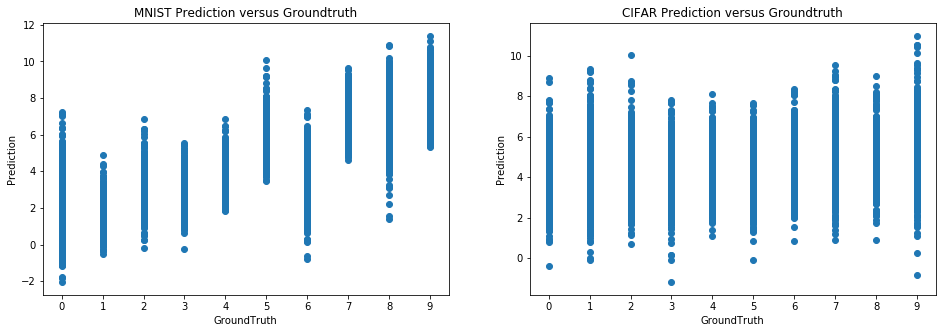

In [43]:
plt.figure(figsize=(16,5))
## MNIST
plt.subplot(121)
print "--- Prediction MSE in MNIST:  " +  str(MSE_regression(mnist_predict, mnist_test_label))
plt.scatter(mnist_test_label, mnist_predict)
plt.xticks(np.unique(mnist_test_label))
plt.xlabel('GroundTruth')
plt.ylabel('Prediction')
plt.title('MNIST Prediction versus Groundtruth')

## CIFAR10
plt.subplot(122)
print "--- Prediction MSE in CIFAR:  " + str(MSE_regression(cifar_predict, cifar_test_label))
plt.scatter(cifar_test_label, cifar_predict)
plt.xticks(np.unique(cifar_test_label))
plt.xlabel('GroundTruth')
plt.ylabel('Prediction')
plt.title('CIFAR Prediction versus Groundtruth')
plt.show()

** Comment **

We see that the predictions of regression spread over a wide range of class labels. But MNIST has smaller range and smaller MSE, this can be interpreted as an indicator that Bayesian Linear Regression performs better than on MNIST than on CIFAR. 


### <font color='green'> 4d. Discretize predictions and Confusion matrix + Accuracy  </font>

We discretize the outputs of regression by rounding them to the nearest class labels among {0..9} in term of Euclidean distance 

** Fashion MNIST & CIFAR10 **

--- Prediction accuracy of Bayesian LR in MNIST ---0.3919
--- Prediction accuracy of Bayesian LR in CIFAR10 ---0.1097


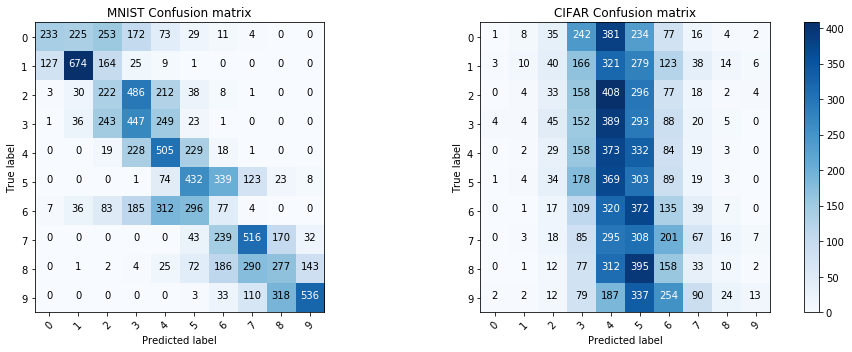

In [49]:
plt.figure(figsize=(16,5))
## MNIST
plt.subplot(121)
# calculate pairwise distance between regression output and each label {0-9}
mnist_dist = pw.pairwise_distances(mnist_predict.reshape(-1,1),np.arange(10).reshape(-1,1))
mnist_discretized_predict = np.argmin(mnist_dist, axis = 1)
print "--- Prediction accuracy of Bayesian LR in MNIST ---" + str(accuracy(mnist_discretized_predict, mnist_test_label))
plot_confusion_matrix(mnist_test_label, mnist_discretized_predict, classes=np.unique(mnist_test_label),title='MNIST Confusion matrix')

## CIFAR 
plt.subplot(122)
# calculate pairwise distance between regression output and each label {0-9}
cifar_dist = pw.pairwise_distances(cifar_predict.reshape(-1,1),np.arange(10).reshape(-1,1))
cifar_discretized_predict = np.argmin(cifar_dist, axis = 1)
print "--- Prediction accuracy of Bayesian LR in CIFAR10 ---" + str(accuracy(cifar_discretized_predict, cifar_test_label))
plot_confusion_matrix(cifar_test_label, cifar_discretized_predict, classes=np.unique(cifar_test_label),title='CIFAR Confusion matrix')
plt.show()

### <font color='green'> 4e. Regression vs Classification performance  </font>

We achieve an accuracy 39% for MNIST and 11% for CIFAR, which are much worse than Naive Bayes Classifier's results (78% for MNIST and 35% for CIFAR). Bayesian regression on CIFAR almost gives predictions concentrated on label 3s-6s, which does not have any useful information.

An explaination for this bad performanace of Bayesian LR can be: targets in the classification are considered as categorical variables that comes from one of {1-9} that is not meaningfully ordered, thus it's not relevant to find a single linear relationship between them and features. 

Instead, we try to mitigate above problem by using MultiClass Bayesian Linear Regression which involving one-hot encoding targets and fitting multiple linear models to each component of them, and classify accordingly to the largest fit. As shown below:

### One hot coding for label

** Encoding discrete class labels **

In [32]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.arange(10).reshape(-1,1))  
def encode_label(label):
    return enc.transform(label.reshape(-1,1)).toarray()

** Discretize predictions ** 

We discretize the outputs of regression by identify the largest component in output vectors and classifiy accordingly 

** Fashion MNIST & CIFAR10 **

--- Prediction accuracy of Bayesian LR in MNIST ---0.8218
--- Prediction accuracy of Bayesian LR in CIFAR ---0.3637


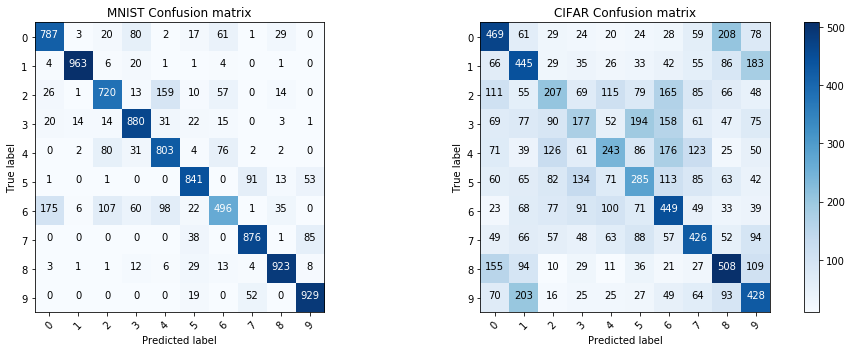

In [55]:
plt.figure(figsize=(16,5))
## MNIST
plt.subplot(121)
# One hot encoding for label
encoded_mnist_train_label = encode_label(mnist_train_label)
encoded_mnist_test_label = encode_label(mnist_test_label)
# MLE fit
mnist_w_hat, mnist_var_hat = MLE_fit(np.hstack((np.array([np.ones(mnist_train.shape[0])]).T, mnist_train)), encoded_mnist_train_label)
# Bayesian Posterior 
mnist_w_hat_posterior,_ = Bayesian_posterior(np.hstack((np.array([np.ones(mnist_train.shape[0])]).T, mnist_train)), encoded_mnist_train_label, mnist_w_prior, mnist_var_hat)
mnist_predict = np.dot(np.hstack((np.array([np.ones(mnist_test.shape[0])]).T, mnist_test)), mnist_w_hat_posterior)
# Discretize output
mnist_discretized_predict = np.argmax(mnist_predict, axis = 1)
print "--- Prediction accuracy of Bayesian LR in MNIST ---" +  str(accuracy(mnist_discretized_predict, mnist_test_label))
plot_confusion_matrix(mnist_test_label, mnist_discretized_predict,classes=np.unique(mnist_test_label),title='MNIST Confusion matrix')

## CIFAR
plt.subplot(122)
# One hot encoding for label
encoded_cifar_train_label = encode_label(cifar_train_label)
encoded_cifar_test_label = encode_label(cifar_test_label)
# MLE fit
cifar_w_hat, cifar_var_hat = MLE_fit(np.hstack((np.array([np.ones(cifar_train.shape[0])]).T, cifar_train)), encoded_cifar_train_label)
# Bayesian Posterior 
cifar_w_hat_posterior,_ = Bayesian_posterior(np.hstack((np.array([np.ones(cifar_train.shape[0])]).T, cifar_train)), encoded_cifar_train_label, cifar_w_prior, cifar_var_hat)
cifar_predict = np.dot(np.hstack((np.array([np.ones(cifar_test.shape[0])]).T, cifar_test)), cifar_w_hat_posterior)
# Discretize output
cifar_discretized_predict = np.argmax(cifar_predict, axis = 1)
print "--- Prediction accuracy of Bayesian LR in CIFAR ---" + str(accuracy(cifar_discretized_predict, cifar_test_label))
plot_confusion_matrix(cifar_test_label, cifar_discretized_predict, classes=np.unique(cifar_test_label),title='CIFAR Confusion matrix')

** Comment **

Now, we indeed improved the performance of Bayesian Linear Regression on both MNIST and CIFAR, and got results comparable (even better)  to Naive Bayes classifier 

### <font color='green'> 4f. Limitation of using regression for classification  </font>

Turning back to our comments in "Classification vs Regression" part, one limitation of using regression for classification is that categorical targets are treated as numerical ones and the assumption of linear relationship between them and features is not usually realistic and easily violated.

Although Multiclass regression is shown to mitigate somewhat this problem, (at least for our MNIST and CIFAR case), it always has significant impact, especially when the number of classes is large. Due to the naive nature of linear regression model, classes can be masked by others. In this case, a polynomial regression rather than linear regression would be expected to solve the problem. 

##  <font color='violet'> 5. Bonus:  </font> 

One deficiency of Naive Bayes classifier or linear regression in image classification is that it does not capture spatial patterns which have proven to be of significant contributions. Here, we try to exploit these kinds of information by training a LeNet5 CNN. Outputs of convolutional layer in LeNet architecture could represent spatial information of images. We then plug these outputs into our classifying models to see whether we can get any improvements when having more complex structural features of image. We consider an LeNet5 implementation by Tensorflow.

** Train and Evaluate Lenet5 model **

In [65]:
def train(init, train_set, train_label, test_set, test_label, sess):
    sess.run(init)
    validation_set = train_set[-5000:]
    validation_label = train_label[-5000:]
    train_set_shuffled = train_set[:-5000]
    train_label_shuffled = train_label[:-5000]
    for epoch in range(training_epochs):
        train_set_shuffled, train_label_shuffled = shuffle(train_set_shuffled, train_label_shuffled)
        total_batch = int(len(train_set_shuffled)/batch_size)
        avg_cost = 0.0
        for i in range(total_batch):
            batch_xs, batch_ys = train_set_shuffled[i*batch_size:(i+1)*batch_size], train_label_shuffled[i*batch_size:(i+1)*batch_size]
            _, c = sess.run([optimizer, loss_operation], feed_dict={x: batch_xs, y: batch_ys})  
            avg_cost += c / total_batch

        train_predict = sess.run(predict, feed_dict={x: train_set_shuffled})
        validation_predict = sess.run(predict, feed_dict={x: validation_set}) 
        train_accuracy = sess.run(accuracy_operation, feed_dict={predict: train_predict, y: train_label_shuffled})
        validation_accuracy = sess.run(accuracy_operation, feed_dict={predict: validation_predict, y: validation_label})
                   
        if (epoch+1) % display_step == 0:
            print("Epoch: ", '%02d' % (epoch+1), "  =====> Loss=", "{:.9f}".format(avg_cost), \
            "  --- Train accuracy =", "{:.9f}".format(train_accuracy) , \
                "  --- Validation accuracy =", "{:.9f}".format(validation_accuracy) )
    print("Optimization Finished!")    
    train_conv_output = sess.run(conv_layer_output, feed_dict={x: train_set})
    test_conv_output = sess.run(conv_layer_output, feed_dict={x: test_set})
    test_predict = sess.run(predict, feed_dict={x: test_set})
    test_accuracy = sess.run(accuracy_operation, feed_dict={predict: test_predict, y: test_label})   
    return test_accuracy, train_conv_output, test_conv_output

** Fashion MNIST **

In [66]:
init = tf.global_variables_initializer()
# reshape input into image and normalize
mnist_train_reshape = mnist_train.reshape((len(mnist_train), 28, 28, 1))/255.0
mnist_test_reshape = mnist_test.reshape((len(mnist_test), 28, 28, 1))/255.0

with tf.Session() as sess:
    test_acc, train_conv, test_conv = train(init, mnist_train_reshape, encoded_mnist_train_label ,mnist_test_reshape, encoded_mnist_test_label, sess)
print(" --- MNIST Prediction accuracy using full leNet5 : ", test_acc, " ---")

Epoch:  05   =====> Loss= 0.297914978   --- Train accuracy = 0.893381834   --- Validation accuracy = 0.874199986
Epoch:  10   =====> Loss= 0.232563106   --- Train accuracy = 0.916236341   --- Validation accuracy = 0.899999976
Optimization Finished!
 --- MNIST Prediction accuracy using full leNet5 :  0.9039  ---


After 20 epchos, LeNet achieves 90% accuracy on Fashion MNIST. Now we extract its convolutional ouput and plug into ** Bayesian Linear regression **

--- Prediction accuracy of Bayesian LR + Conv Lenet5 in MNIST --- 0.8359


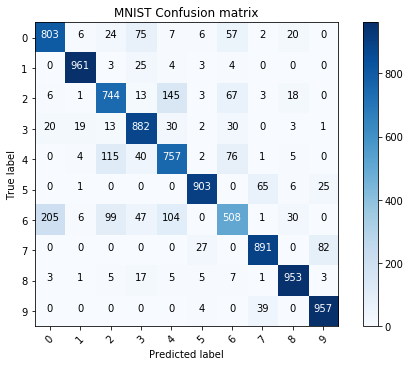

In [51]:
# Prior
mnist_w_prior = {}
mnist_w_prior['mean'] = np.zeros(train_conv.shape[1] + 1)
mnist_w_prior['inv_cov'] = np.eye(train_conv.shape[1] + 1)
# MLE fit
mnist_w_hat, mnist_var_hat = MLE_fit(np.hstack((np.array([np.ones(train_conv.shape[0])]).T, train_conv)), encoded_mnist_train_label)
# Bayesian Posterior 
mnist_w_hat_posterior,_ = Bayesian_posterior(np.hstack((np.array([np.ones(train_conv.shape[0])]).T, train_conv)), encoded_mnist_train_label, mnist_w_prior, mnist_var_hat)
mnist_predict = np.dot(np.hstack((np.array([np.ones(test_conv.shape[0])]).T, test_conv)), mnist_w_hat_posterior)

mnist_discretized_predict = np.argmax(mnist_predict, axis = 1)
print("--- Prediction accuracy of Bayesian LR + Conv Lenet5 in MNIST ---", accuracy(mnist_discretized_predict, mnist_test_label))
plot_confusion_matrix(mnist_test_label, mnist_discretized_predict, classes=np.unique(mnist_test_label),title='MNIST Confusion matrix')

By exploiting patch information, Bayesian LR got a slightly better accuracy than previous PCA-based one (0.84 vs 0.82). But we may expect a clearer improvement when comparing it to a fully connected neural network with same convolutional input, which gives 89% accuracy